In [1]:
#@test {"skip": true}
#!sudo apt-get update
#!sudo apt-get install -y xvfb ffmpeg python-opengl
#!pip install pyglet
#!pip install 'imageio==2.4.0'
#!pip install 'xvfbwrapper==0.2.9'
#!pip install tf-agents[reverb]
#!python -m pip install gym
#!python -m pip install tf-agents
#!python -m pip install gym[atari]
#!python -m pip install autorom
#!AutoROM -y
#!python -m pip install opencv-python
#!pip install autorom[accept-rom-license]
#!pip install "gymnasium[atari, accept-rom-license]"
#!apt update
#!apt install -y xvfb
#!pip install -U pyvirtualdisplay
#!pip install ale-py
#!pip install gym gym[atari] autorom[accept-rom-license] tf-agents

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
!pip install --upgrade tensorflow
import base64
import imageio
import io
import matplotlib
import matplotlib.pyplot as plt
import os
import shutil
import tempfile
import tensorflow as tf
import zipfile
import IPython

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

2023-06-15 16:25:28.022563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 16:25:28.939833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-15 16:25:28.939944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [3]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:

#@test {"skip": true}
# Set up a virtual display for rendering OpenAI gym environments.
import xvfbwrapper
xvfbwrapper.Xvfb(1400, 900, 24).start()

In [5]:
# Defining my Hyperparameters 
env_name = "MsPacman-v4"

collect_steps_per_iteration = 100
replay_buffer_capacity = 100000

fc_layer_params = (100,)

batch_size = 64
learning_rate = 2.5e-4
log_interval = 1000

num_eval_episodes = 10
eval_interval = 1000

In [6]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [7]:
train_env.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(210, 160, 3), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [17]:
# Agent 
#@title
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

global_step = tf.compat.v1.train.get_or_create_global_step()

'''optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step)
agent.initialize()'''

from tf_agents.agents.dqn.dqn_agent import DqnAgent
# see TF-agents issue #113
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0,   
epsilon=0.00001, centered=True)
train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
#optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95,
# momentum=0.0,epsilon=0.00001, centered=True)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ?
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ?
agent = DqnAgent(train_env.time_step_spec(),
                train_env.action_spec(),
                q_network=q_net,
                optimizer=optimizer,
                target_update_period=2000, # <=> 32,000 ALE frames
                td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
                gamma=0.99, # discount factor
                train_step_counter=global_step,
                epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

## Epsilon Greedy not implemenetd ? 

In [18]:
#Data Collection
#@title
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

# Initial data collection
collect_driver.run()

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

2023-06-15 16:30:10.630995: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 10080000000 exceeds 10% of free system memory.


In [19]:
# Train the agent 
#@title
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

def train_one_iteration():
    policy_state = agent.collect_policy.get_initial_state(eval_env.batch_size)

  # Collect a few steps using collect_policy and save to the replay buffer.
    collect_driver.run()


  # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience)

    iteration = agent.train_step_counter.numpy()
    print ('iteration: {0} loss: {1}'.format(iteration, train_loss.loss))

In [27]:
# Video Generation
#@title
def embed_gif(gif_buffer):
  """Embeds a gif file in the notebook."""
  tag = ''.format(base64.b64encode(gif_buffer).decode())
  return IPython.display.HTML(tag)
import os
import PIL

def run_episodes_and_create_video(policy, eval_tf_env, eval_py_env):
    num_episodes = 3
    frames = []
    for _ in range(num_episodes):
        time_step = eval_tf_env.reset()
        frames.append(eval_py_env.render())
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_tf_env.step(action_step.action)
            frames.append(eval_py_env.render())
    # Save frames as GIF file
    image_path = os.path.join("images", "rl", "MsPacman.gif")
    frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
    frame_images[0].save(image_path, format='GIF',
                          append_images=frame_images[1:],
                          save_all=True,
                          duration=30,
                          loop=0)
    
    # Display the GIF file
    IPython.display.display(IPython.display.Image(filename=image_path))

global_step:
<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>


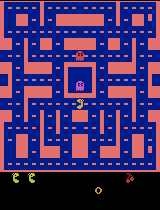

In [28]:
#Generate a Video 
print ('global_step:')
print (global_step)
run_episodes_and_create_video(agent.policy, eval_env, eval_py_env)

In [29]:
#Setup Checkpointer and Policy Saver 
checkpoint_dir = os.path.join('Checkpoint', 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

2023-06-15 16:32:16.815341: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 10080000000 exceeds 10% of free system memory.


In [30]:
#Policy Saver 
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [31]:
#Train one iteration 
#@test {"skip": true}
print('Training one iteration....')
train_one_iteration()

Training one iteration....
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


iteration: 2 loss: 221.88699340820312


In [32]:
# Save to checkpoint 
train_checkpointer.save(global_step)

In [33]:
# Restor Checkpointer 
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [34]:
#Saving Policy and exporting to a location 
tf_policy_saver.save(policy_dir)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:523: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /var/tmp/policy/assets


INFO:tensorflow:Assets written to: /var/tmp/policy/assets


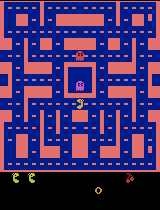

In [35]:
# Loading the Policy and checking how it performs 
saved_policy = tf.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)

In [36]:
#Export and Import 
#@title Create zip file and upload zip file (double-click to see the code)
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

In [37]:
# Creating a zipped file from the checkpoint directory 
train_checkpointer.save(global_step)
checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))

In [39]:
# Downloading the Zip file 
#@test {"skip": true}
if files is not None:
  files.download(checkpoint_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

NameError: name 'files' is not defined

In [38]:
#After training for some time (10-15 times), download the checkpoint zip file, and go to "Runtime > Restart and run all" to reset the training, and come back to this cell. Now you can upload the downloaded zip file, and continue the training.
#@test {"skip": true}
upload_and_unzip_file_to(checkpoint_dir)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

NameError: name 'files' is not defined

In [40]:
#Alternatively, you can save the policy (model) and restore it. Unlike checkpointer, you cannot continue with the training, but you can still deploy the model. Note that the downloaded file is much smaller than that of the checkpointer
tf_policy_saver.save(policy_dir)
policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, 'exported_policy'))

#@test {"skip": true}
if files is not None:
  files.download(policy_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

/opt/conda/lib/python3.7/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:523: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  "imported and registered." % type_spec_class_name)


INFO:tensorflow:Assets written to: /var/tmp/policy/assets


INFO:tensorflow:Assets written to: /var/tmp/policy/assets


NameError: name 'files' is not defined

In [ ]:
#Upload the downloaded policy directory (exported_policy.zip) and check how the saved policy performs.
#@test {"skip": true}
upload_and_unzip_file_to(policy_dir)
saved_policy = tf.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)

In [41]:
checkpoint_interval=1000

iteration: 3 loss: 1120.7296142578125


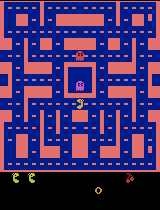

iteration: 4 loss: 545.45068359375
iteration: 5 loss: 329.801513671875
iteration: 6 loss: 248.90293884277344
iteration: 7 loss: 214.46083068847656
iteration: 8 loss: 127.61384582519531
iteration: 9 loss: 300.6832275390625
iteration: 10 loss: 168.18692016601562
iteration: 11 loss: 212.9955596923828
iteration: 12 loss: 122.73693084716797
iteration: 13 loss: 121.42356872558594
iteration: 14 loss: 165.5375518798828
iteration: 15 loss: 144.1683807373047
iteration: 16 loss: 155.3126220703125
iteration: 17 loss: 129.12437438964844
iteration: 18 loss: 155.66165161132812
iteration: 19 loss: 111.9857177734375
iteration: 20 loss: 44.08905792236328
iteration: 21 loss: 136.47462463378906
iteration: 22 loss: 120.1670150756836
iteration: 23 loss: 74.2586669921875
iteration: 24 loss: 58.06727600097656
iteration: 25 loss: 80.23863220214844
iteration: 26 loss: 65.70185852050781
iteration: 27 loss: 56.45203399658203
iteration: 28 loss: 112.36369323730469
iteration: 29 loss: 64.03112030029297
iteration: 3

KeyboardInterrupt: 

In [42]:
# Resume Training
num_iterations = 500  # Set the desired number of additional iterations

for iteration in range(num_iterations):
    train_one_iteration()

    if iteration % eval_interval == 0:
        run_episodes_and_create_video(agent.policy, eval_env, eval_py_env)

    if iteration % checkpoint_interval == 0:
        train_checkpointer.save(global_step)

# Save the final trained model
tf_policy_saver.save(policy_dir)